In [1]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

# EDA

In [2]:
df = pd.read_csv('data/sentiment_analysis.csv')
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [3]:
df.dtypes

Year              int64
Month             int64
Day               int64
Time of Tweet    object
text             object
sentiment        object
Platform         object
dtype: object

In [4]:
df.isnull().sum()

Year             0
Month            0
Day              0
Time of Tweet    0
text             0
sentiment        0
Platform         0
dtype: int64

For this project i will only use the text and the sentiment tag. I don't think the date or the platform are that relevant for text classification.

In [5]:
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,What a great day!!! Looks like dream.,positive
1,"I feel sorry, I miss you here in the sea beach",positive
2,Don't angry me,negative
3,We attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",negative


## Sentiment labels

### Checking different sentiment values

In [6]:
df.sentiment.unique()

array(['positive', 'negative', 'neutral'], dtype=object)

### Checking sentiment distribution

In [7]:
df.sentiment.value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

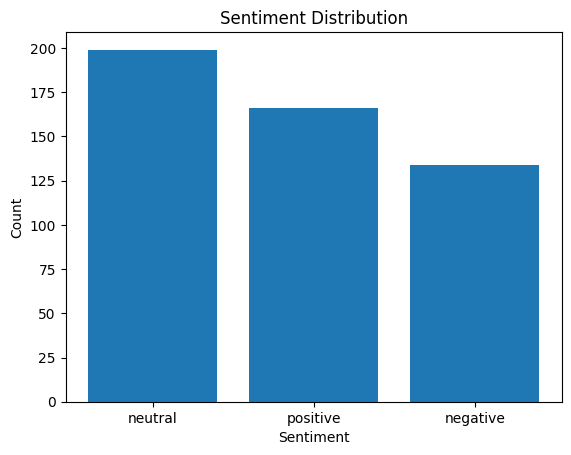

In [8]:
sentiment_count = df.sentiment.value_counts()
plt.bar(sentiment_count.index, sentiment_count.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

### Encoding sentiment labels

In [9]:
label_encoder = LabelEncoder()
label_encoder.fit(df.sentiment)
label_mapping = {label:encoded_label for label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
print(label_mapping)

{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [10]:
df.sentiment = label_encoder.transform(df.sentiment)

In [11]:
df.head()

,text,sentiment
0,What a great day!!! Looks like dream.,2
1,"I feel sorry, I miss you here in the sea beach",2
2,Don't angry me,0
3,We attend in the class just for listening teac...,0
4,"Those who want to go, let them go",0


## Preprocess text

### Lowercase

In [12]:
df.text = df.text.str.lower()
df.head()

,text,sentiment
0,what a great day!!! looks like dream.,2
1,"i feel sorry, i miss you here in the sea beach",2
2,don't angry me,0
3,we attend in the class just for listening teac...,0
4,"those who want to go, let them go",0


### Remove punctuation marks

In [13]:
df.text = df.text.str.replace('[{}]'.format(string.punctuation), '', regex=True)
df.head()

,text,sentiment
0,what a great day looks like dream,2
1,i feel sorry i miss you here in the sea beach,2
2,dont angry me,0
3,we attend in the class just for listening teac...,0
4,those who want to go let them go,0


### Remove stop words

In [14]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df.text = df.text.apply(lambda t: ' '.join(w for w in t.split() if w not in stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kasteion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df.head()

,text,sentiment
0,great day looks like dream,2
1,feel sorry miss sea beach,2
2,dont angry,0
3,attend class listening teachers reading slide ...,0
4,want go let go,0


## Validation Framework

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = df.text
y = df.sentiment

In [18]:
df_full_train, df_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=42)

In [19]:
df_train.head()

434        httptwitpiccom4wukt bought ludi rug dogs best
398                        nothing aimed joining insorry
277    laughs im glad self confidence wonderful trait...
37     case wonder really busy today coming adding to...
146                                           thats need
Name: text, dtype: object

In [20]:
y_train.head()

434    2
398    0
277    2
37     1
146    2
Name: sentiment, dtype: int64

In [21]:
print(f'Shape of df_train: {df_train.shape}')
print(f'Shape of df_val: {df_val.shape}')
print(f'Shape of df_test: {df_test.shape}')

total_size = len(df_train)+len(df_val)+len(df_test)
print(f'total dataset size: {total_size}')
print(f'train %: {len(df_train)/total_size*100}')
print(f'val %: {len(df_val)/total_size*100}')
print(f'test %: {len(df_test)/total_size*100}')

Shape of df_train: (299,)
Shape of df_val: (100,)
Shape of df_test: (100,)
total dataset size: 499
train %: 59.919839679358724
val %: 20.04008016032064
test %: 20.04008016032064


## Model training

### Logistic regression (Term frequency)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [23]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=8000)
X_train_counts = count_vectorizer.fit_transform(df_train, y_train)
X_val_counts = count_vectorizer.transform(df_val)
X_test_counts = count_vectorizer.transform(df_test)

In [24]:
print(X_train_counts.shape)
# Calculate the frequencies
word_frequencies = np.array(X_train_counts.sum(axis=0))[0]
# Get the indexes that would sort the word frequencies
sorted_indexes = np.argsort(word_frequencies)
# Get the vocabulary words corresponding to the indexes
vocabulary_words = np.array(count_vectorizer.get_feature_names_out())
# Get the top and bottom frequent words
top_10_tokens = vocabulary_words[sorted_indexes[-10:]][::-1]
bottom_10_tokens = vocabulary_words[sorted_indexes[:10]]

print("Top 10 frequent tokens:")
print(top_10_tokens)

print("\nBottom 10 frequent tokens:")
print(bottom_10_tokens)


(299, 2354)
Top 10 frequent tokens:
['im' 'day' 'go' 'going' 'know' 'love' 'happy' 'like' 'today' 'dont']

Bottom 10 frequent tokens:
['zero funny' 'lol dammit' 'thank teaching' 'logo' 'lobster weekend'
 'lobster' 'lmao smh' 'lmao' 'lm days' 'lm']


In [25]:
clr = LogisticRegression(random_state=42)
clr.fit(X_train_counts, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [26]:
def get_accuracy(model, X_data_split, y_data_split, split_name):
    y_pred = model.predict(X_data_split)
    score = accuracy_score(y_data_split, y_pred)
    print(f'Accuracy on {split_name}: {score}')
    return score

def get_auc(model, X_data_split, y_data_split, split_name):
    y_pred = model.predict_proba(X_data_split)
    score = roc_auc_score(y_data_split, y_pred, multi_class='ovo')
    print(f'Area under the curve on {split_name}: {score}')
    return score

In [27]:
get_auc(clr, X_train_counts, y_train, 'train')
get_auc(clr, X_val_counts, y_val, 'val')
get_auc(clr, X_test_counts, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.8206397487127491
Area under the curve on test: 0.856454248366013


np.float64(0.856454248366013)

In [28]:
get_accuracy(clr, X_train_counts, y_train, 'train')
get_accuracy(clr, X_val_counts, y_val, 'val')
get_accuracy(clr, X_test_counts, y_test, 'test')

Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.58


0.58

In [29]:
for solver in ['newton-cg', 'newton-cholesky', 'sag', 'saga']:
    clr = LogisticRegression(solver=solver, random_state=42)
    clr.fit(X_train_counts, y_train)

    print(solver, "->")
    get_auc(clr, X_train_counts, y_train, 'train')
    get_auc(clr, X_val_counts, y_val, 'val')
    get_auc(clr, X_test_counts, y_test, 'test')

    get_accuracy(clr, X_train_counts, y_train, 'train')
    get_accuracy(clr, X_val_counts, y_val, 'val')
    get_accuracy(clr, X_test_counts, y_test, 'test')
    print()

newton-cg ->
Area under the curve on train: 1.0
Area under the curve on val: 0.8205055565495716
Area under the curve on test: 0.8566085693536675
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.58

newton-cholesky ->
Area under the curve on train: 1.0
Area under the curve on val: 0.82078885111628
Area under the curve on test: 0.8566085693536675
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.58

sag ->
Area under the curve on train: 1.0
Area under the curve on val: 0.8175682392000159
Area under the curve on test: 0.8518881626724765
Accuracy on train: 1.0
Accuracy on val: 0.71
Accuracy on test: 0.62

saga ->
Area under the curve on train: 1.0
Area under the curve on val: 0.815744219796823
Area under the curve on test: 0.8497095134350037
Accuracy on train: 1.0
Accuracy on val: 0.72
Accuracy on test: 0.62



/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [30]:
for C in [0.01, 0.1, 1, 10, 100]:
    clr = LogisticRegression(solver="saga", C=C, random_state=42)
    clr.fit(X_train_counts, y_train)

    print("C =", C, "->")
    get_auc(clr, X_train_counts, y_train, 'train')
    get_auc(clr, X_val_counts, y_val, 'val')
    get_auc(clr, X_test_counts, y_test, 'test')

    get_accuracy(clr, X_train_counts, y_train, 'train')
    get_accuracy(clr, X_val_counts, y_val, 'val')
    get_accuracy(clr, X_test_counts, y_test, 'test')
    print()

C = 0.01 ->
Area under the curve on train: 0.9949092931573178
Area under the curve on val: 0.7820619868392278
Area under the curve on test: 0.8230301379811183
Accuracy on train: 0.6120401337792643
Accuracy on val: 0.54
Accuracy on test: 0.37

C = 0.1 ->
Area under the curve on train: 0.9996386630532973
Area under the curve on val: 0.7975686368064253
Area under the curve on test: 0.8377904865649963
Accuracy on train: 0.9732441471571907
Accuracy on val: 0.66
Accuracy on test: 0.58

C = 1 ->
Area under the curve on train: 1.0
Area under the curve on val: 0.815744219796823
Area under the curve on test: 0.8497095134350037
Accuracy on train: 1.0
Accuracy on val: 0.72
Accuracy on test: 0.62

C = 10 ->
Area under the curve on train: 1.0
Area under the curve on val: 0.8167432059004791
Area under the curve on test: 0.8442628903413217
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.63

C = 100 ->
Area under the curve on train: 1.0
Area under the curve on val: 0.8155752370728216
A

/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site

In [31]:
from sklearn.model_selection import RandomizedSearchCV

In [32]:
model = LogisticRegression(random_state=42)

param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],  # Range for regularization strength (log-scale)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # choice of optimizing algorithm
    'max_iter': np.arange(100, 500, 100),  # Range for maximum iterations
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_counts, y_train)

/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'C': [0.01, 0.1, ...], 'max_iter': array([100, 200, 300, 400]), 'solver': ['newton-cg', 'lbfgs', ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``

In [33]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

# Fit the model on train data
best_clr = LogisticRegression(**best_params, random_state=42)
best_clr.fit(X_train_counts, y_train)


Best Hyperparameters: {'solver': 'sag', 'max_iter': np.int64(100), 'C': 100}
Best Accuracy Score: 0.6624293785310734


/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",100
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [34]:
get_auc(best_clr, X_train_counts, y_train, 'train')
get_auc(best_clr, X_val_counts, y_val, 'val')
get_auc(best_clr, X_test_counts, y_test, 'test')

get_accuracy(best_clr, X_train_counts, y_train, 'train')
get_accuracy(best_clr, X_val_counts, y_val, 'val')
get_accuracy(best_clr, X_test_counts, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.8115991729786683
Area under the curve on test: 0.8358024691358025
Accuracy on train: 1.0
Accuracy on val: 0.67
Accuracy on test: 0.65


0.65

### Logistic regression (TF-IDF)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=8000)
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train, y_train)
X_val_tfidf = tfidf_vectorizer.transform(df_val)
X_test_tfidf = tfidf_vectorizer.transform(df_test)

In [37]:
tfidflr = LogisticRegression(random_state=42)
tfidflr.fit(X_train_tfidf, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [38]:
get_auc(tfidflr, X_train_tfidf, y_train, 'train')
get_auc(tfidflr, X_val_tfidf, y_val, 'val')
get_auc(tfidflr, X_test_tfidf, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.7947655116200473
Area under the curve on test: 0.8461147421931736


np.float64(0.8461147421931736)

In [39]:
get_accuracy(tfidflr, X_train_tfidf, y_train, 'train')
get_accuracy(tfidflr, X_val_tfidf, y_val, 'val')
get_accuracy(tfidflr, X_test_tfidf, y_test, 'test')

Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58


0.58

In [40]:
for solver in ['newton-cg', 'newton-cholesky', 'sag', 'saga']:
    tfidflr = LogisticRegression(solver=solver, max_iter=500, random_state=42)
    tfidflr.fit(X_train_tfidf, y_train)

    print(solver, "->")
    get_auc(tfidflr, X_train_tfidf, y_train, 'train')
    get_auc(tfidflr, X_val_tfidf, y_val, 'val')
    get_auc(tfidflr, X_test_tfidf, y_test, 'test')

    get_accuracy(tfidflr, X_train_tfidf, y_train, 'train')
    get_accuracy(tfidflr, X_val_tfidf, y_val, 'val')
    get_accuracy(tfidflr, X_test_tfidf, y_test, 'test')
    print()

newton-cg ->
Area under the curve on train: 1.0
Area under the curve on val: 0.794994135305461
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58

newton-cholesky ->
Area under the curve on train: 1.0
Area under the curve on val: 0.794994135305461
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58

sag ->
Area under the curve on train: 1.0
Area under the curve on val: 0.794994135305461
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58

saga ->
Area under the curve on train: 1.0
Area under the curve on val: 0.7950885668276971
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58



In [41]:
for C in [0.01, 0.1, 1, 10, 100]:
    tfidflr = LogisticRegression(C=C, random_state=42)
    tfidflr.fit(X_train_tfidf, y_train)

    print("C =", C, "->")
    get_auc(tfidflr, X_train_tfidf, y_train, 'train')
    get_auc(tfidflr, X_val_tfidf, y_val, 'val')
    get_auc(tfidflr, X_test_tfidf, y_test, 'test')

    get_accuracy(tfidflr, X_train_tfidf, y_train, 'train')
    get_accuracy(tfidflr, X_val_tfidf, y_val, 'val')
    get_accuracy(tfidflr, X_test_tfidf, y_test, 'test')
    print()

C = 0.01 ->
Area under the curve on train: 0.9991942622310194
Area under the curve on val: 0.7872606906423331
Area under the curve on test: 0.8314088598402325
Accuracy on train: 0.411371237458194
Accuracy on val: 0.46
Accuracy on test: 0.3

C = 0.1 ->
Area under the curve on train: 0.9996335738005268
Area under the curve on val: 0.7877875191348084
Area under the curve on test: 0.8312273057371096
Accuracy on train: 0.5351170568561873
Accuracy on val: 0.49
Accuracy on test: 0.35

C = 1 ->
Area under the curve on train: 1.0
Area under the curve on val: 0.7947655116200473
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58

C = 10 ->
Area under the curve on train: 1.0
Area under the curve on val: 0.8045068686507227
Area under the curve on test: 0.8556190994916486
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.64

C = 100 ->
Area under the curve on train: 1.0
Area under the curve on val: 0.8096

In [42]:
model = LogisticRegression(random_state=42)

param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],  # Range for regularization strength (log-scale)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # choice of optimizing algorithm
    'max_iter': np.arange(100, 500, 100),  # Range for maximum iterations
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_tfidf, y_train)

/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'C': [0.01, 0.1, ...], 'max_iter': array([100, 200, 300, 400]), 'solver': ['newton-cg', 'lbfgs', ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``

In [43]:
# Get the best hyperparameters and corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

# Fit the model on train data
best_tfidflr = LogisticRegression(**best_params, random_state=42)
best_tfidflr.fit(X_train_tfidf, y_train) 

Best Hyperparameters: {'solver': 'newton-cg', 'max_iter': np.int64(300), 'C': 10}
Best Accuracy Score: 0.6223728813559322


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",10
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multic

In [44]:
get_auc(best_tfidflr, X_train_counts, y_train, 'train')
get_auc(best_tfidflr, X_val_counts, y_val, 'val')
get_auc(best_tfidflr, X_test_counts, y_test, 'test')

get_accuracy(best_tfidflr, X_train_counts, y_train, 'train')
get_accuracy(best_tfidflr, X_val_counts, y_val, 'val')
get_accuracy(best_tfidflr, X_test_counts, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.8210423252022823
Area under the curve on test: 0.8472222222222222
Accuracy on train: 1.0
Accuracy on val: 0.65
Accuracy on test: 0.66


0.66

Using a `CountVectorizer` the best results were achieved using `solver='sag'`, `max_iter=100`, and `C=100`.

Using a `TfidfVectorizer` the best results were achieved using `solver='newton-cg'`, `max_iter=300`, `C=10`.

### Decission Tree Classifier

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
cdt = DecisionTreeClassifier(random_state=42)
cdt.fit(X_train_counts, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [47]:
get_auc(cdt, X_train_counts, y_train, 'train')
get_auc(cdt, X_val_counts, y_val, 'val')
get_auc(cdt, X_test_counts, y_test, 'test')

get_accuracy(cdt, X_train_counts, y_train, 'train')
get_accuracy(cdt, X_val_counts, y_val, 'val')
get_accuracy(cdt, X_test_counts, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.7342995169082127
Area under the curve on test: 0.7236928104575164
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.62


0.62

In [48]:
model = DecisionTreeClassifier(random_state=42)

param_dist = {
    'max_depth': [1, 2, 3, 4, 5, 6, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 100, 200, 500],
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_counts, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [1, 2, ...], 'min_samples_leaf': [1, 2, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fo

In [49]:
# Get the best hyperparameters and corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

# Fit the model on train data
best_cdt = DecisionTreeClassifier(**best_params, random_state=42)
best_cdt.fit(X_train_counts, y_train) 

Best Hyperparameters: {'min_samples_leaf': 1, 'max_depth': None}
Best Accuracy Score: 0.5989265536723164


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [50]:
get_auc(best_cdt, X_train_counts, y_train, 'train')
get_auc(best_cdt, X_val_counts, y_val, 'val')
get_auc(best_cdt, X_test_counts, y_test, 'test')

get_accuracy(best_cdt, X_train_counts, y_train, 'train')
get_accuracy(best_cdt, X_val_counts, y_val, 'val')
get_accuracy(best_cdt, X_test_counts, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.7342995169082127
Area under the curve on test: 0.7236928104575164
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.62


0.62

In [51]:
tfidfdt = DecisionTreeClassifier(random_state=42)
tfidfdt.fit(X_train_tfidf, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [52]:
get_auc(tfidfdt, X_train_counts, y_train, 'train')
get_auc(tfidfdt, X_val_counts, y_val, 'val')
get_auc(tfidfdt, X_test_counts, y_test, 'test')

get_accuracy(tfidfdt, X_train_counts, y_train, 'train')
get_accuracy(tfidfdt, X_val_counts, y_val, 'val')
get_accuracy(tfidfdt, X_test_counts, y_test, 'test')

Area under the curve on train: 0.9058922641540299
Area under the curve on val: 0.71256038647343
Area under the curve on test: 0.6698529411764707
Accuracy on train: 0.8595317725752508
Accuracy on val: 0.64
Accuracy on test: 0.55


0.55

In [53]:
model = DecisionTreeClassifier(random_state=42)

param_dist = {
    'max_depth': [1, 2, 3, 4, 5, 6, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 100, 200, 500],
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_tfidf, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [1, 2, ...], 'min_samples_leaf': [1, 2, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fo

In [54]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

best_tfidfdt = DecisionTreeClassifier(**best_params, random_state=42)
best_tfidfdt.fit(X_train_counts, y_train) 

Best Hyperparameters: {'min_samples_leaf': 1, 'max_depth': None}
Best Accuracy Score: 0.5685875706214689


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [55]:
get_auc(best_tfidfdt, X_train_counts, y_train, 'train')
get_auc(best_tfidfdt, X_val_counts, y_val, 'val')
get_auc(best_tfidfdt, X_test_counts, y_test, 'test')

get_accuracy(best_tfidfdt, X_train_counts, y_train, 'train')
get_accuracy(best_tfidfdt, X_val_counts, y_val, 'val')
get_accuracy(best_tfidfdt, X_test_counts, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.7342995169082127
Area under the curve on test: 0.7236928104575164
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.62


0.62

### Random Forest Classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
crf = RandomForestClassifier(n_estimators=10, random_state=42)
crf.fit(X_train_counts, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [58]:
get_auc(crf, X_train_counts, y_train, 'train')
get_auc(crf, X_val_counts, y_val, 'val')
get_auc(crf, X_test_counts, y_test, 'test')

get_accuracy(crf, X_train_counts, y_train, 'train')
get_accuracy(crf, X_val_counts, y_val, 'val')
get_accuracy(crf, X_test_counts, y_test, 'test')

Area under the curve on train: 0.9990566706471894
Area under the curve on val: 0.77118496650166
Area under the curve on test: 0.7705746187363834
Accuracy on train: 0.9565217391304348
Accuracy on val: 0.65
Accuracy on test: 0.55


0.55

In [59]:
model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': range(10, 201, 10),
    'max_depth': [1, 2, 3, 4, 5, 6, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 100, 200, 500]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_counts, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [1, 2, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': range(10, 201, 10)}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` def

In [60]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

best_crf = RandomForestClassifier(**best_params, random_state=42)
best_crf.fit(X_train_counts, y_train) 

Best Hyperparameters: {'n_estimators': 190, 'min_samples_leaf': 1, 'max_depth': None}
Best Accuracy Score: 0.582316384180791


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",190
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [61]:
get_auc(best_crf, X_train_counts, y_train, 'train')
get_auc(best_crf, X_val_counts, y_val, 'val')
get_auc(best_crf, X_test_counts, y_test, 'test')

get_accuracy(best_crf, X_train_counts, y_train, 'train')
get_accuracy(best_crf, X_val_counts, y_val, 'val')
get_accuracy(best_crf, X_test_counts, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.8042434544044851
Area under the curve on test: 0.8323665577342046
Accuracy on train: 1.0
Accuracy on val: 0.63
Accuracy on test: 0.54


0.54

In [62]:
tfidfrf = RandomForestClassifier(n_estimators=10, random_state=42)
tfidfrf.fit(X_train_tfidf, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [63]:
get_auc(tfidfrf, X_train_tfidf, y_train, 'train')
get_auc(tfidfrf, X_val_tfidf, y_val, 'val')
get_auc(tfidfrf, X_test_tfidf, y_test, 'test')

get_accuracy(tfidfrf, X_train_tfidf, y_train, 'train')
get_accuracy(tfidfrf, X_val_tfidf, y_val, 'val')
get_accuracy(tfidfrf, X_test_tfidf, y_test, 'test')

Area under the curve on train: 0.9992529703969072
Area under the curve on val: 0.7530739945527921
Area under the curve on test: 0.8013934277414668
Accuracy on train: 0.9498327759197325
Accuracy on val: 0.63
Accuracy on test: 0.57


0.57

In [64]:
model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': range(10, 201, 10),
    'max_depth': [1, 2, 3, 4, 5, 6, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 100, 200, 500]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_tfidf, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [1, 2, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': range(10, 201, 10)}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` def

In [65]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)

best_tfidfrf = RandomForestClassifier(**best_params, random_state=42)
best_tfidfrf.fit(X_train_tfidf, y_train)

Best Hyperparameters: {'n_estimators': 190, 'min_samples_leaf': 1, 'max_depth': None}
Best Accuracy Score: 0.5755367231638419


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",190
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [66]:
get_auc(best_tfidfrf, X_train_tfidf, y_train, 'train')
get_auc(best_tfidfrf, X_val_tfidf, y_val, 'val')
get_auc(best_tfidfrf, X_test_tfidf, y_test, 'test')

get_accuracy(best_tfidfrf, X_train_tfidf, y_train, 'train')
get_accuracy(best_tfidfrf, X_val_tfidf, y_val, 'val')
get_accuracy(best_tfidfrf, X_test_tfidf, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.7917287926681378
Area under the curve on test: 0.8370506535947712
Accuracy on train: 1.0
Accuracy on val: 0.67
Accuracy on test: 0.64


0.64

### XGBoost

In [67]:
from xgboost import XGBClassifier

In [68]:
cbst = XGBClassifier()
cbst.fit(X_train_counts, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [69]:
get_auc(cbst, X_train_counts, y_train, 'train')
get_auc(cbst, X_val_counts, y_val, 'val')
get_auc(cbst, X_test_counts, y_test, 'test')

get_accuracy(cbst, X_train_counts, y_train, 'train')
get_accuracy(cbst, X_val_counts, y_val, 'val')
get_accuracy(cbst, X_test_counts, y_test, 'test')

Area under the curve on train: 0.9801735435194727
Area under the curve on val: 0.7089819287886922
Area under the curve on test: 0.7476397966594046
Accuracy on train: 0.8762541806020067
Accuracy on val: 0.64
Accuracy on test: 0.58


0.58

In [70]:
tfidfbst = XGBClassifier()
tfidfbst.fit(X_train_tfidf, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [71]:
get_auc(tfidfbst, X_train_counts, y_train, 'train')
get_auc(tfidfbst, X_val_counts, y_val, 'val')
get_auc(tfidfbst, X_test_counts, y_test, 'test')

get_accuracy(tfidfbst, X_train_counts, y_train, 'train')
get_accuracy(tfidfbst, X_val_counts, y_val, 'val')
get_accuracy(tfidfbst, X_test_counts, y_test, 'test')

Area under the curve on train: 0.7525410820841945
Area under the curve on val: 0.6411850659032624
Area under the curve on test: 0.7058914306463326
Accuracy on train: 0.5652173913043478
Accuracy on val: 0.55
Accuracy on test: 0.53


0.53

## Neural Network

In [72]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score


In [73]:
class SentimentNet(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [74]:
class WordsDataset(Dataset):
    def __init__(self, tfidf_vectors, labels):
        self.X = tfidf_vectors            # scipy sparse
        self.y = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].toarray().squeeze(0)
        x = torch.from_numpy(x).float()
        y = self.y[idx]
        return x, y


In [75]:
c_train_dataset = WordsDataset(X_train_counts, y_train)
c_val_dataset = WordsDataset(X_val_counts, y_val)
c_test_dataset = WordsDataset(X_test_counts, y_test)

In [76]:
batch_size = 32

In [77]:
c_train_dataloader = DataLoader(c_train_dataset, batch_size=batch_size, shuffle=True)
c_test_dataloader = DataLoader(c_test_dataset, batch_size=batch_size, shuffle=True)
c_val_dataloader = DataLoader(c_val_dataset, batch_size=batch_size, shuffle=True)

In [78]:
cnet = SentimentNet(input_dim=X_train_counts.shape[1])
optimizer = torch.optim.Adam(cnet.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [79]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [80]:
cnet = cnet.to(device)

In [81]:
def train_nn(net, optimizer, criterion, train_dataloader, valid_dataloader, n_epochs = 3):
    len_train_dataloader = len(train_dataloader)
    len_valid_dataloader = len(valid_dataloader)
    train_losses, valid_losses = [], []

    for epoch in range(n_epochs):  # loop over the dataset
        total_train_loss = 0.0
        net.train()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device) # move data to the device
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients

            outputs = net(inputs) # forward + backward + optimize
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        with torch.no_grad():
            net.eval()
            total_valid_loss = 0
            for data in valid_dataloader:
                valid_inputs, valid_labels = data
                valid_inputs = valid_inputs.to(device)
                valid_labels = valid_labels.to(device)
                outputs = net(valid_inputs)
                total_valid_loss += criterion(outputs, valid_labels).item() 
        train_losses.append(total_train_loss/len_train_dataloader)
        valid_losses.append(total_valid_loss/len_valid_dataloader)
    print('Finished Training')
    return train_losses, valid_losses

In [82]:
n_epochs = 4

In [83]:
train_losses, valid_losses = train_nn(cnet, optimizer, criterion,  c_train_dataloader, c_val_dataloader, n_epochs = n_epochs)

Finished Training


In [84]:
def evaluate_classnet(model, dataloader):
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
    accuracy = 100 * correct // total
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    print(f'Accuracy: {accuracy} %')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    return predictions, accuracy

In [85]:
predictions, accuracy = evaluate_classnet(cnet, c_test_dataloader)  

Accuracy: 65 %
Precision: 0.41464320625610945
Recall: 0.41949891067538125
F1 Score: 0.40720811881955316


In [86]:
tfidf_train_dataset = WordsDataset(X_train_tfidf, y_train)
tfidf_val_dataset = WordsDataset(X_val_tfidf, y_val)
tfidf_test_dataset = WordsDataset(X_test_tfidf, y_test)

tfidf_train_dataloader = DataLoader(tfidf_train_dataset, batch_size=batch_size, shuffle=True)
tfidf_test_dataloader = DataLoader(tfidf_test_dataset, batch_size=batch_size, shuffle=True)
tfidf_val_dataloader = DataLoader(tfidf_val_dataset, batch_size=batch_size, shuffle=True)

tfidfnet = SentimentNet(input_dim=X_train_tfidf.shape[1])
optimizer = torch.optim.Adam(tfidfnet.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

tfidfnet = cnet.to(device)

train_losses, valid_losses = train_nn(tfidfnet, optimizer, criterion,  tfidf_train_dataloader, tfidf_val_dataloader, n_epochs = n_epochs)

predictions, accuracy = evaluate_classnet(tfidfnet, tfidf_test_dataloader)  

Finished Training
Accuracy: 66 %
Precision: 0.3725708168642951
Recall: 0.37657952069716777
F1 Score: 0.3630399528232345


## Fine-Tuning DistilBERT

In [ ]:
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)

In [88]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = tokenize(df_train.to_list())
val_encodings = tokenize(df_val.to_list())
test_encodings = tokenize(df_test.to_list())

type(df_train)

pandas.core.series.Series

In [103]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = SentimentDataset(train_encodings, y_train.tolist())
val_dataset   = SentimentDataset(val_encodings, y_val.tolist())


In [90]:
finetuned_distilbert = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,          # VERY important
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs"
)

In [93]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [104]:
trainer = Trainer(
    model=finetuned_distilbert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [105]:
trainer.train()

/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.046809,0.560000,0.427186
2,No log,0.898921,0.570000,0.440801
3,No log,0.785453,0.720000,0.710134
4,No log,0.726914,0.710000,0.696667
5,No log,0.699695,0.770000,0.769515


/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but 

TrainOutput(global_step=190, training_loss=0.7459661383377878, metrics={'train_runtime': 28.3964, 'train_samples_per_second': 52.647, 'train_steps_per_second': 6.691, 'total_flos': 11604040589700.0, 'train_loss': 0.7459661383377878, 'epoch': 5.0})

In [ ]:
def predict(texts):
    device = finetuned_distilbert.device

    inputs = tokenize(texts)

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = finetuned_distilbert(**inputs)

    preds = torch.argmax(outputs.logits, dim=1)
    return preds.cpu().tolist()

# predict(["I really love this app"])
# predict(["her family is comming home later"])
# predict(["This is terrible! The worst thing ever"])
# predict(["I really hate this"])

[0]